In [1]:
import numpy as np
import pandas as pd
from os import environ
import seaborn as sns
import tqdm.auto as tqdm
from analysis.plot_matplotlib import plot_hist
import matplotlib.pyplot as plt
print(environ['LD_LIBRARY_PATH'])

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

tf.keras.backend.set_floatx('float64')

# Example for adding to LD_LIBRARY_PATH:
# in CONDA_ENV_ROOT/etc/conda/activate.d/env_vars.sh

# #!/bin/sh
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/root/ILCSoft/LCIO/build/lib64:/root/ILCSoft/Physsim/lib64:/root/miniforge3/envs/graphjet_pyg/lib

/nfs/dust/ilc/user/bliewert/miniconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/afs/desy.de/user/b/bliewert/public/ILCSoft/LCIO/lib64:/afs/desy.de/user/b/bliewert/public/ILCSoft/Physsim/lib64:


In [2]:
from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma

In [3]:
from iflow.integration import integrator
from iflow.integration import couplings
from analysis.nis.masks import binary_masks

In [4]:
def build(in_features, out_features, options, init_debug:bool=False, nhidden:int=4, nchannels:int=256):
    """ Builds a dense NN.

    The output layer is initialized to 0, so the first pass
    before training gives the identity transformation.

    Arguments:
        in_features (int): dimensionality of the inputs space
        out_features (int): dimensionality of the output space
        options: additional arguments, not used at the moment

    Returns:
        A tf.keras.models.Model instance

    """
    del options
    
    bias_initializer = tf.constant_initializer(value=0.01) if init_debug else None
    kernel_initializer = tf.constant_initializer(value=0.01) if init_debug else None

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(nchannels, activation='relu', bias_initializer=bias_initializer, kernel_initializer=kernel_initializer)(invals)
    for i in range(nhidden - 1):
        hidden = tf.keras.layers.Dense(nchannels, activation='relu', bias_initializer=bias_initializer, kernel_initializer=kernel_initializer)(hidden)
    #hidden = tf.keras.layers.Dense(32, activation='relu', bias_initializer=bias_initializer, kernel_initializer=kernel_initializer)(hidden)
    #hidden = tf.keras.layers.Dense(32, activation='relu', bias_initializer=bias_initializer, kernel_initializer=kernel_initializer)(hidden)
    outputs = tf.keras.layers.Dense(out_features, bias_initializer='zeros',
                                    kernel_initializer='zeros')(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [5]:
from analysis.mc.tools import variance_weighted_result
from typing import Optional, Callable

def train_iflow(integrate:integrator.Integrator, ptspepoch:int, epochs:int,
                test_callback:Optional[Callable]=None, test_callback_freq:int=50):
    """ Run the iflow integrator

    Args:
        integrate (Integrator): iflow Integrator class object
        ptspepoch (int): number of points per epoch in training
        epochs (int): number of epochs for training

    Returns:
        numpy.ndarray(float): value of loss (mean) and its uncertainty (standard deviation)

    """
    means = np.zeros(epochs)
    stddevs = np.zeros(epochs)
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        loss, integral, error = integrate.train_one_step(ptspepoch, integral=True)
        means[epoch] = integral
        stddevs[epoch] = error
        losses[epoch] = loss
        _, current_precision = variance_weighted_result(means[:epoch+1], stddevs[:epoch+1])
        if epoch % 10 == 0:
            print('Epoch: {:3d} Loss = {:8e} Integral = '
                  '{:8e} +/- {:8e} Total uncertainty = {:8e}'.format(epoch, loss,
                                                                     integral, error,
                                                                     current_precision))
        
        if epoch % test_callback_freq == 0 and test_callback is not None:
            test_callback(integrate)

    return means, stddevs, losses

In [6]:
tf.keras.backend.set_floatx('float64')

def build_flow_dist(boundaries:np.ndarray, nbins:int=16):
    # Calculate scale and hist
    ndims = len(boundaries)
    width = (boundaries[:, 1] - boundaries[:, 0])
    shift = (boundaries[:, 1] + boundaries[:, 0])/2 - width/2

    base = tfd.Uniform(low=np.zeros(ndims, dtype=np.float64), high=np.ones(ndims, dtype=np.float64))
    bijectors = []

    for mask in binary_masks(ndims):
        bijectors.append(couplings.PiecewiseRationalQuadratic(mask, build, num_bins=nbins, options=None))

    bijectors.append(tfp.bijectors.Scale(width))
    bijectors.append(tfp.bijectors.Shift(shift))

    bijector = tfb.Chain(list(reversed(bijectors)))

    return tfd.TransformedDistribution(distribution=tfd.Independent(distribution=base, reinterpreted_batch_ndims=1), bijector=bijector)

def build_integrator(dist, func, lr=1e-3, optimizer_args:dict={}, integrator_args:dict={}):
    optim_args = { 'clipnorm': 10.0,  **optimizer_args }
    optimizer = tf.keras.optimizers.Adam(lr, **optim_args)
    
    integr_args = { 'loss_func': 'exponential', **integrator_args }
    integrate = integrator.Integrator(func, dist, optimizer, **integr_args)

    return integrate

def plot_marginals(dist, n_samples:int=10000, is_dist:bool=False, separate:bool=True, plot_args:dict={}, plot_grid=(2,4), plot_size=(20, 10)):
    samples = dist.sample(n_samples).numpy()
    plt_args={ 'scientific_stats': True, **plot_args }
    
    if not separate:
        all_max = np.max(samples).max()
        all_min = np.min(samples).min()
        dfbase = {}
        for i in range(len(samples.T)):
            dfbase[f'x{i}'] = samples.T[i]

        return plot_hist(pd.DataFrame(dfbase), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max), **plt_args)
    else:
        fig, axes = plt.subplots(nrows=plot_grid[0], ncols=plot_grid[1], figsize=plot_size)
        for i in range(samples.shape[1]):
            plot_hist({ f'Dim {i+1}': samples.T[i] }, normalize=True, ax=axes.flat[i], **plt_args)
        
        to_del = int(np.prod(plot_grid) - len(samples.T))
        for j in range(to_del):
            fig.delaxes(axes.flat[-(j+1)])
        
        return fig, axes

In [7]:
from analysis.import_data import import_true_reco
from analysis.calc import get_kinematics
from typing import Callable

def build_integrand(reco_kin, print_ps_efficiciency:bool=True)->Callable:
    def integrand(vars:np.ndarray, mode=1, me_type=1):
        #return np.sum(vars, axis=-1)
        
        if print_ps_efficiciency:
            tf.print(f"PS points given:found [{len(vars)}:", end="")
        
        res = mc_batch(reco_kin, vars.flatten().tolist(), mode=mode, me_type=me_type)
        
        found = np.count_nonzero(res)
        efficiency = found/len(vars)
        
        if print_ps_efficiciency:
            tf.print(f"{found}] ({(100*efficiency):6.2f} %) ")
        
        return tf.convert_to_tensor(res, dtype=tf.float64), tf.convert_to_tensor(efficiency, dtype=tf.float64)
    
    return integrand

df = import_true_reco()

Using cached file from /nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/cache/comparison_reco_zhh_zzh.npy


In [8]:
df[df['event'] == 7336]

,run,event,error_code,is_zhh,is_zzh,passed_preselection,true_h1_decay_pdg,true_h2_decay_pdg,true_z2_decay_pdg,misclustering_region,...,zzh_mzzh,zzh_mh,zzh_phi,zzh_phiz,zzh_phiz1f,zzh_phiz2f,zzh_costheta,zzh_costhetaz,zzh_costhetaz1f,zzh_costhetaz2f
2233,403001,7336,0,1,0,1,5,5,0,0,...,502.487244,126.311089,2.805492,0.473305,0.963528,0.812207,0.404936,-0.577895,-0.585455,0.068774


In [16]:
from math import pi

boundaries = np.array([
    [0, pi],
    [-pi, pi],
    [0, 200],
    
    [0, pi],
    [-pi, pi],
    
    [0, 200],
    [0, pi]
], dtype=np.float64)

reco_kin = get_kinematics(df, False, i=2233, perm=[1,2,3,4])

In [17]:
dist = build_flow_dist(boundaries, nbins=32)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_34 (Dense)             (None, 388)               99716     
Total params: 298,116
Trainable params: 298,116
Non-trainable params: 0
_____________________________________________________

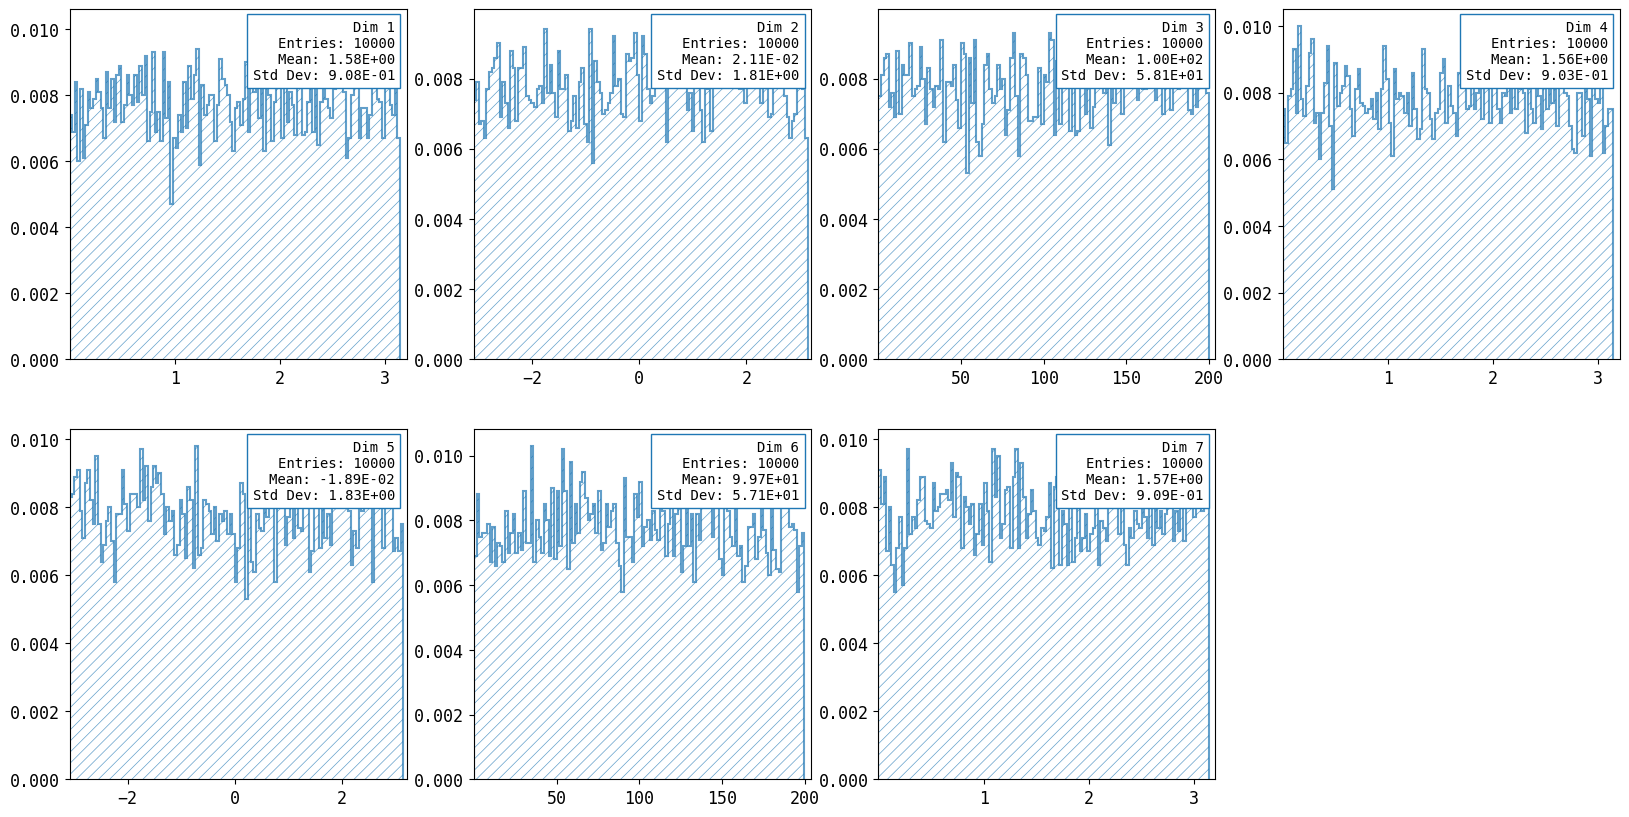

In [18]:
plot_marginals(dist, separate=True);

In [19]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
integrand = build_integrand(reco_kin)

PS points given:found [1024:74] (  7.23 %) 
Epoch:   0 Loss = 4.376482e+01 Integral = 1.588765e-24 +/- 1.448071e-24 Total uncertainty = 1.448071e-24
PS points given:found [1024:80] (  7.81 %) 
PS points given:found [1024:88] (  8.59 %) 
PS points given:found [1024:66] (  6.45 %) 
PS points given:found [1024:76] (  7.42 %) 
PS points given:found [1024:69] (  6.74 %) 
PS points given:found [1024:78] (  7.62 %) 
PS points given:found [1024:88] (  8.59 %) 
PS points given:found [1024:86] (  8.40 %) 
PS points given:found [1024:67] (  6.54 %) 
PS points given:found [1024:74] (  7.23 %) 
Epoch:  10 Loss = 4.804530e+01 Integral = 1.279724e-15 +/- 1.279724e-15 Total uncertainty = 2.044713e-25
PS points given:found [1024:81] (  7.91 %) 
PS points given:found [1024:87] (  8.50 %) 
PS points given:found [1024:98] (  9.57 %) 
PS points given:found [1024:80] (  7.81 %) 
PS points given:found [1024:96] (  9.38 %) 
PS points given:found [1024:88] (  8.59 %) 
PS points given:found [1024:91] (  8.89 %)

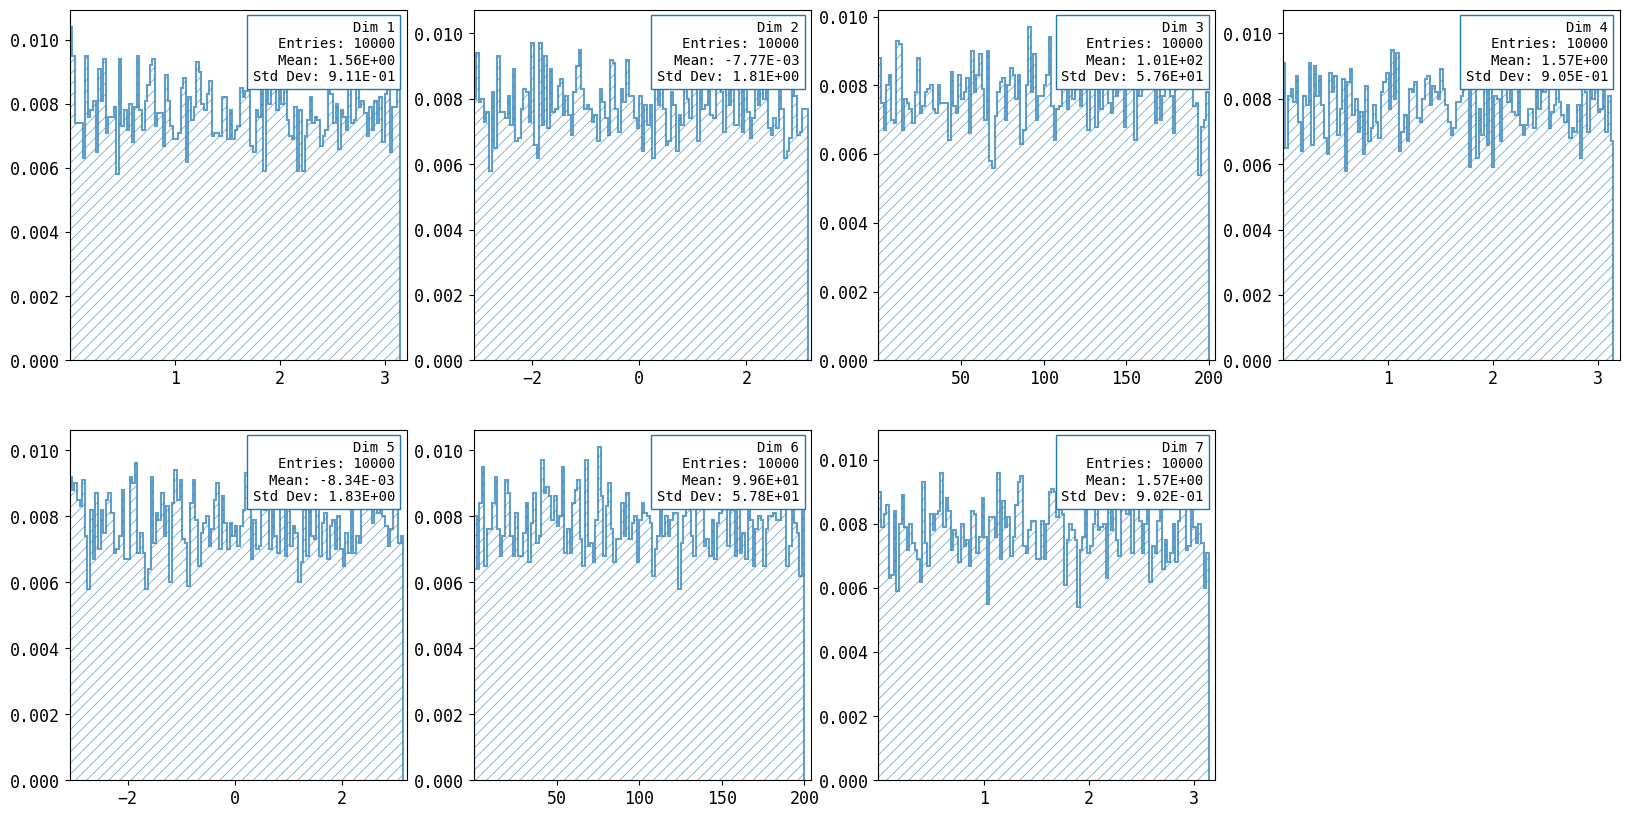

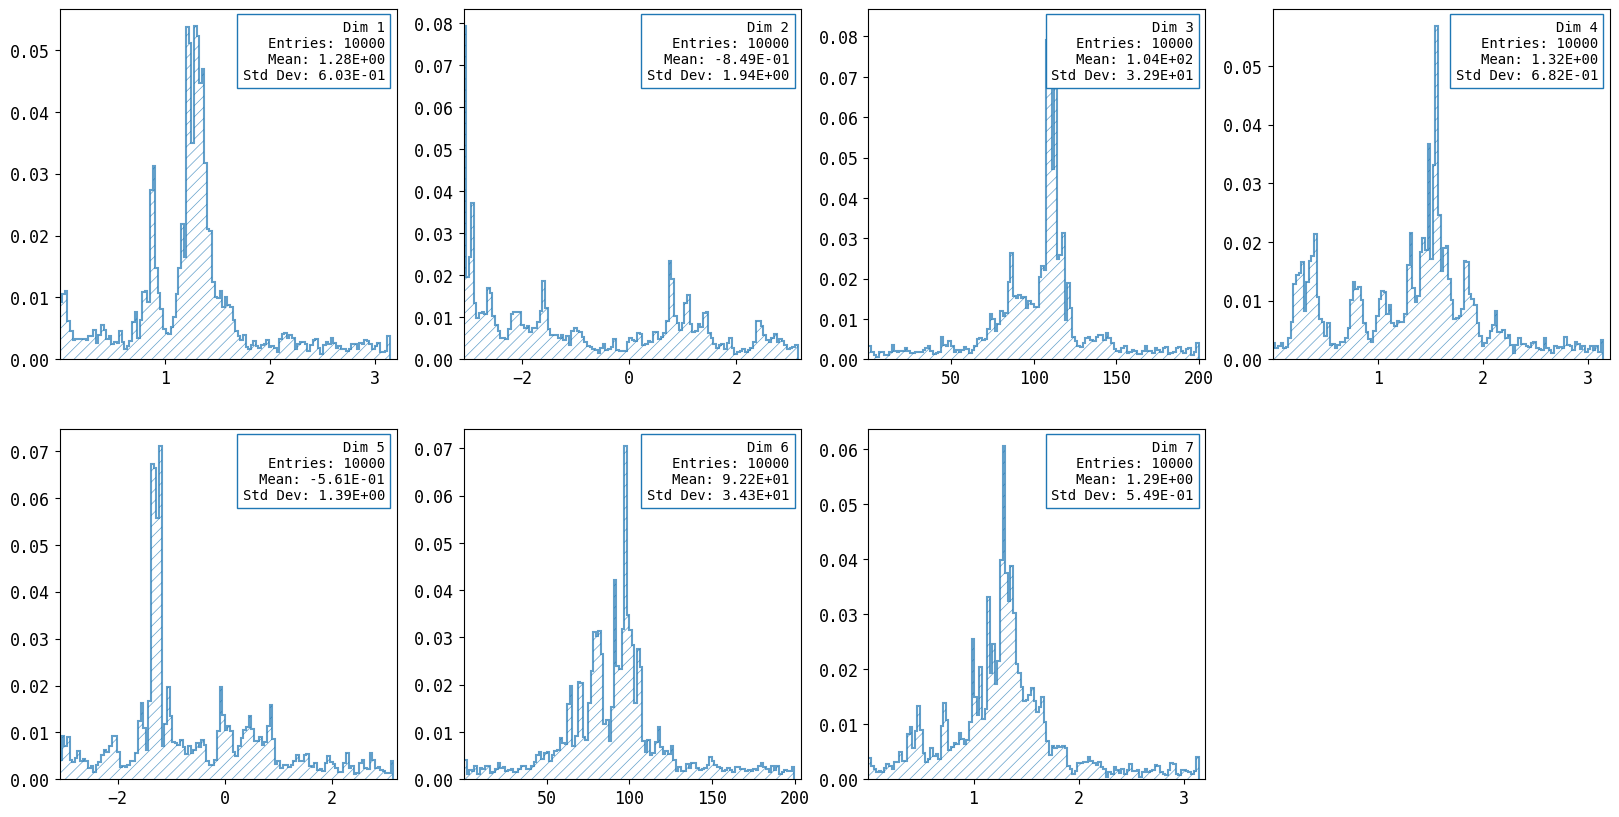

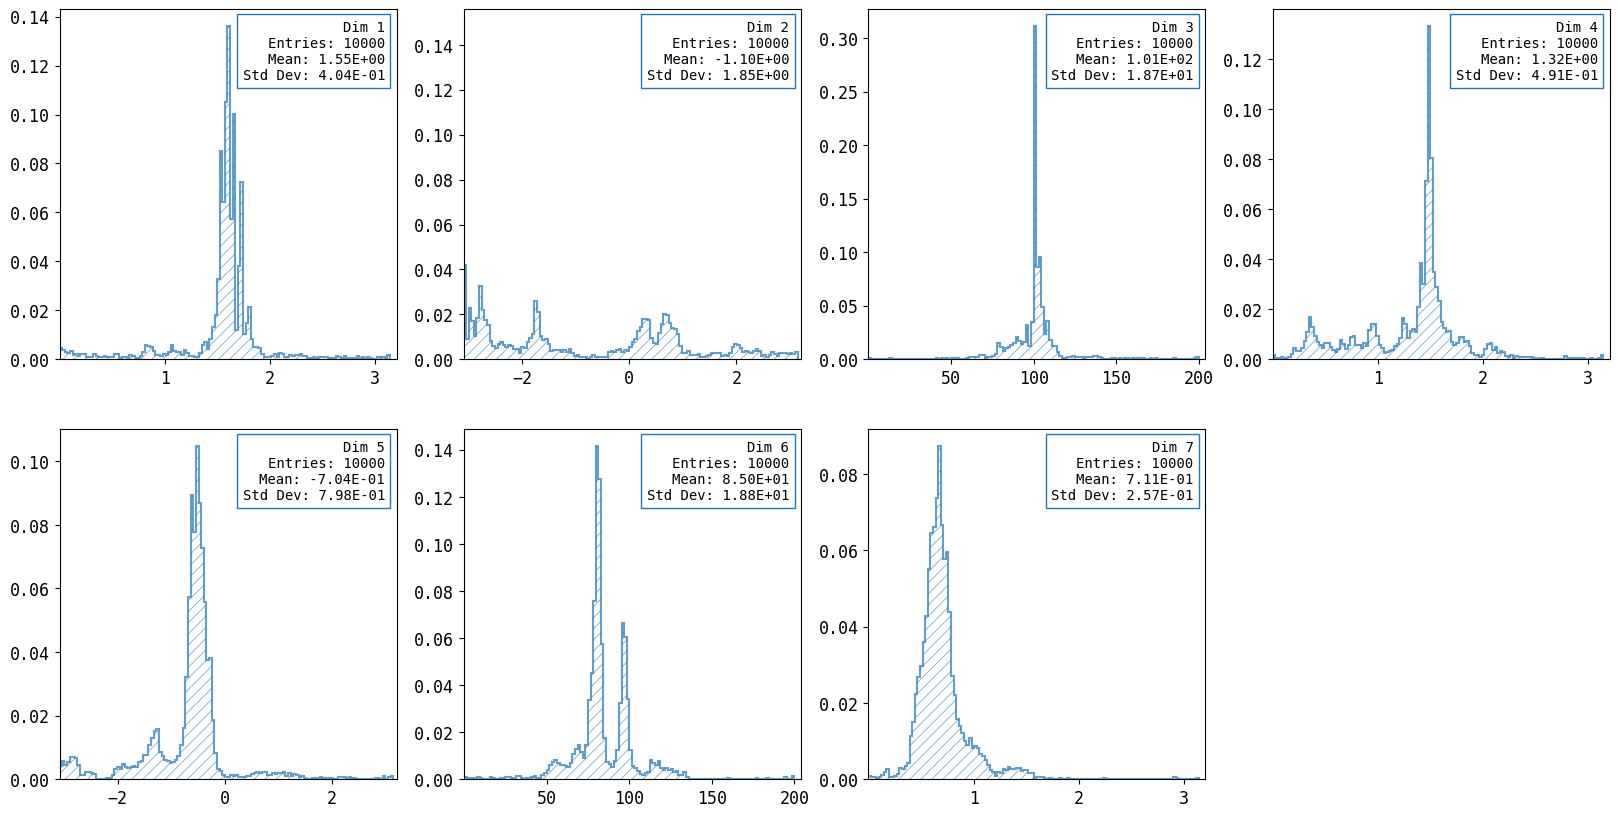

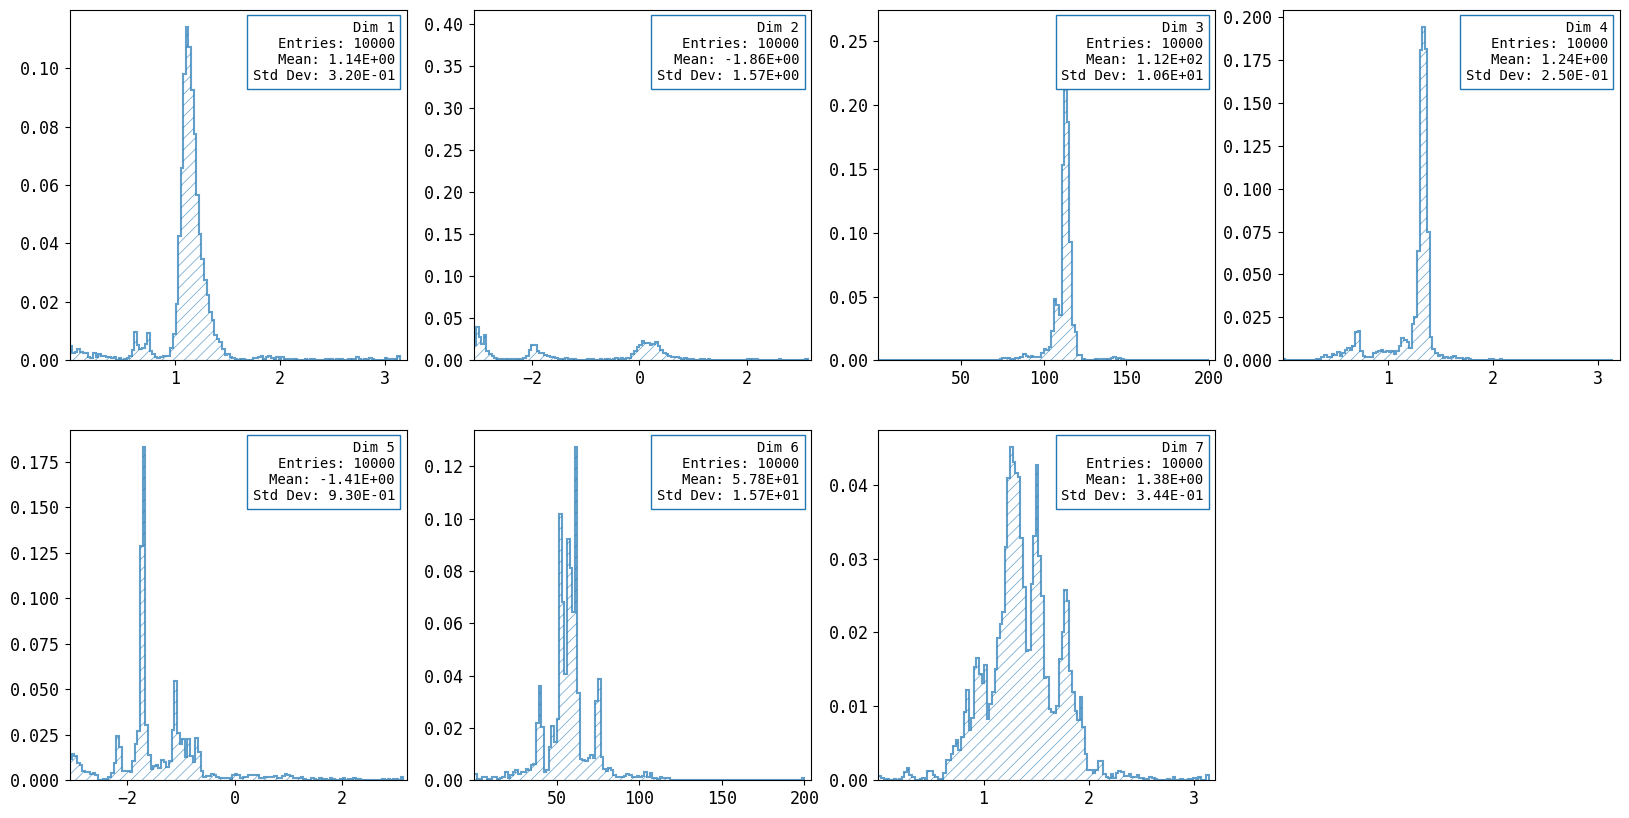

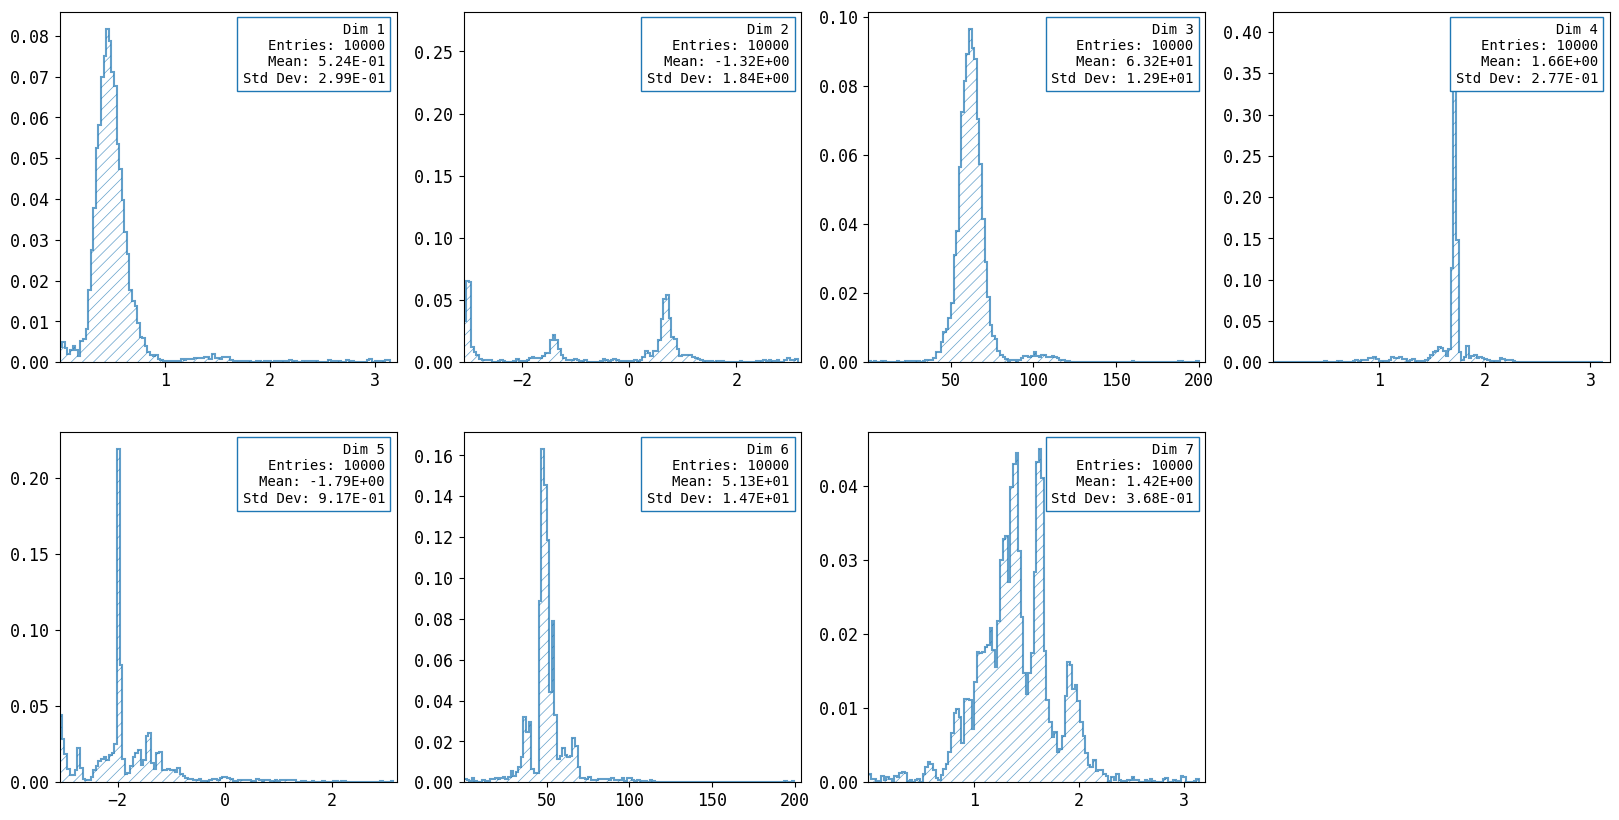

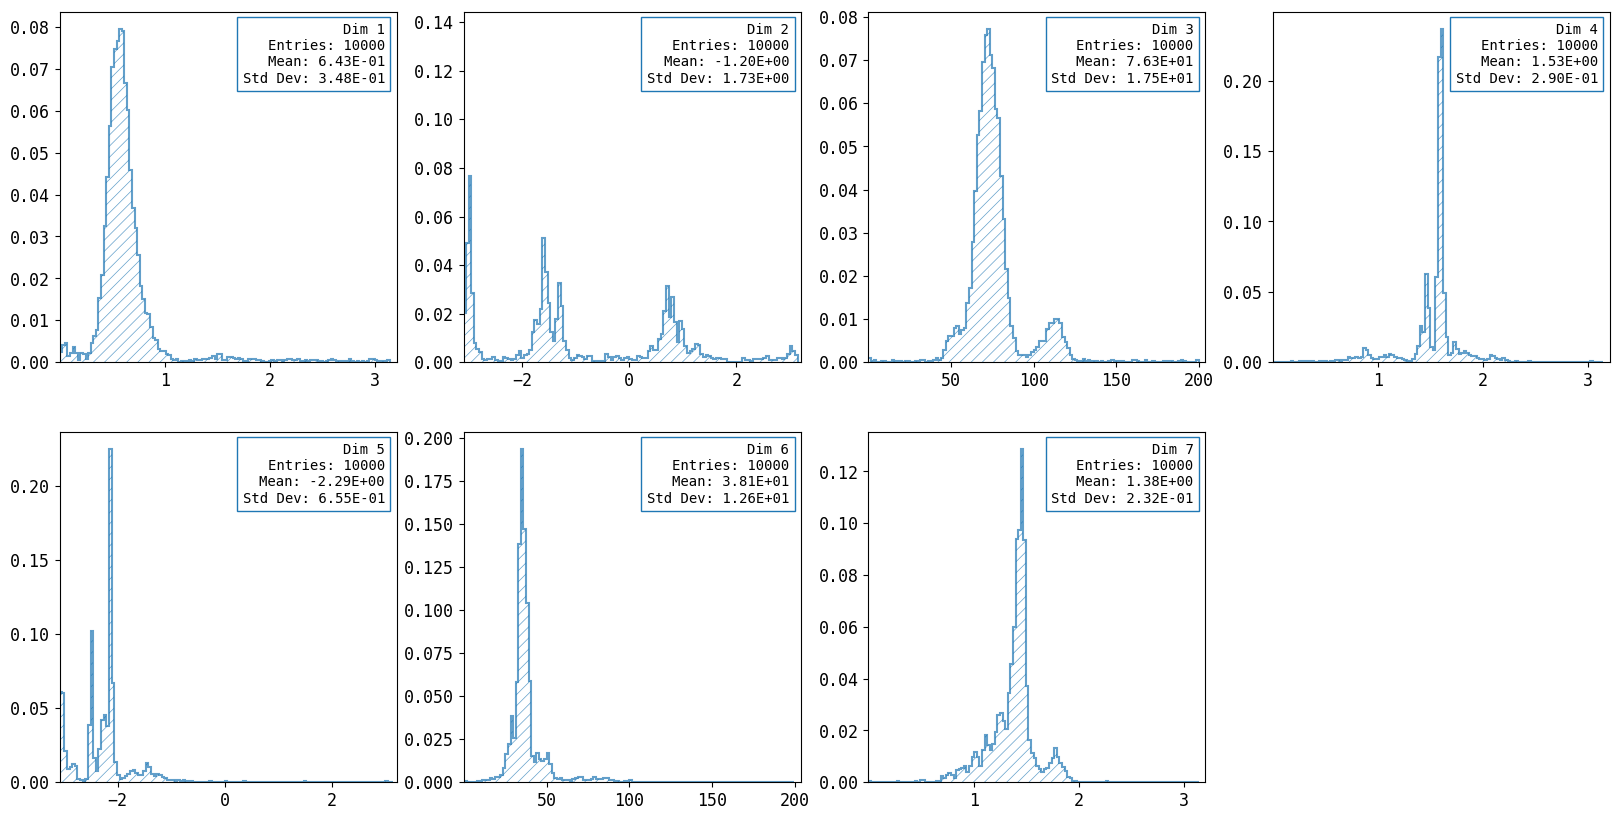

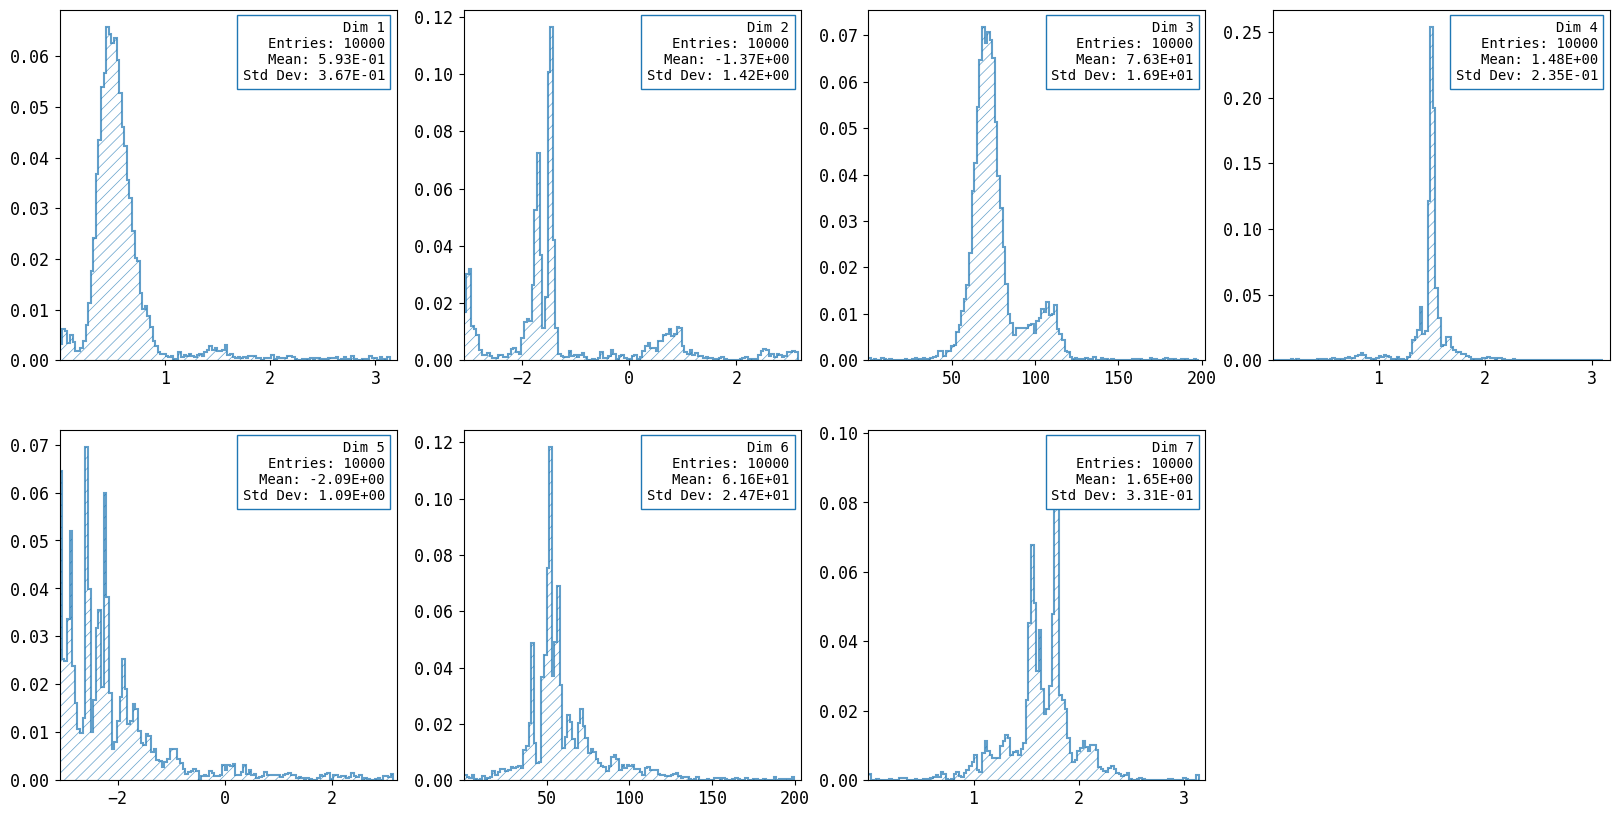

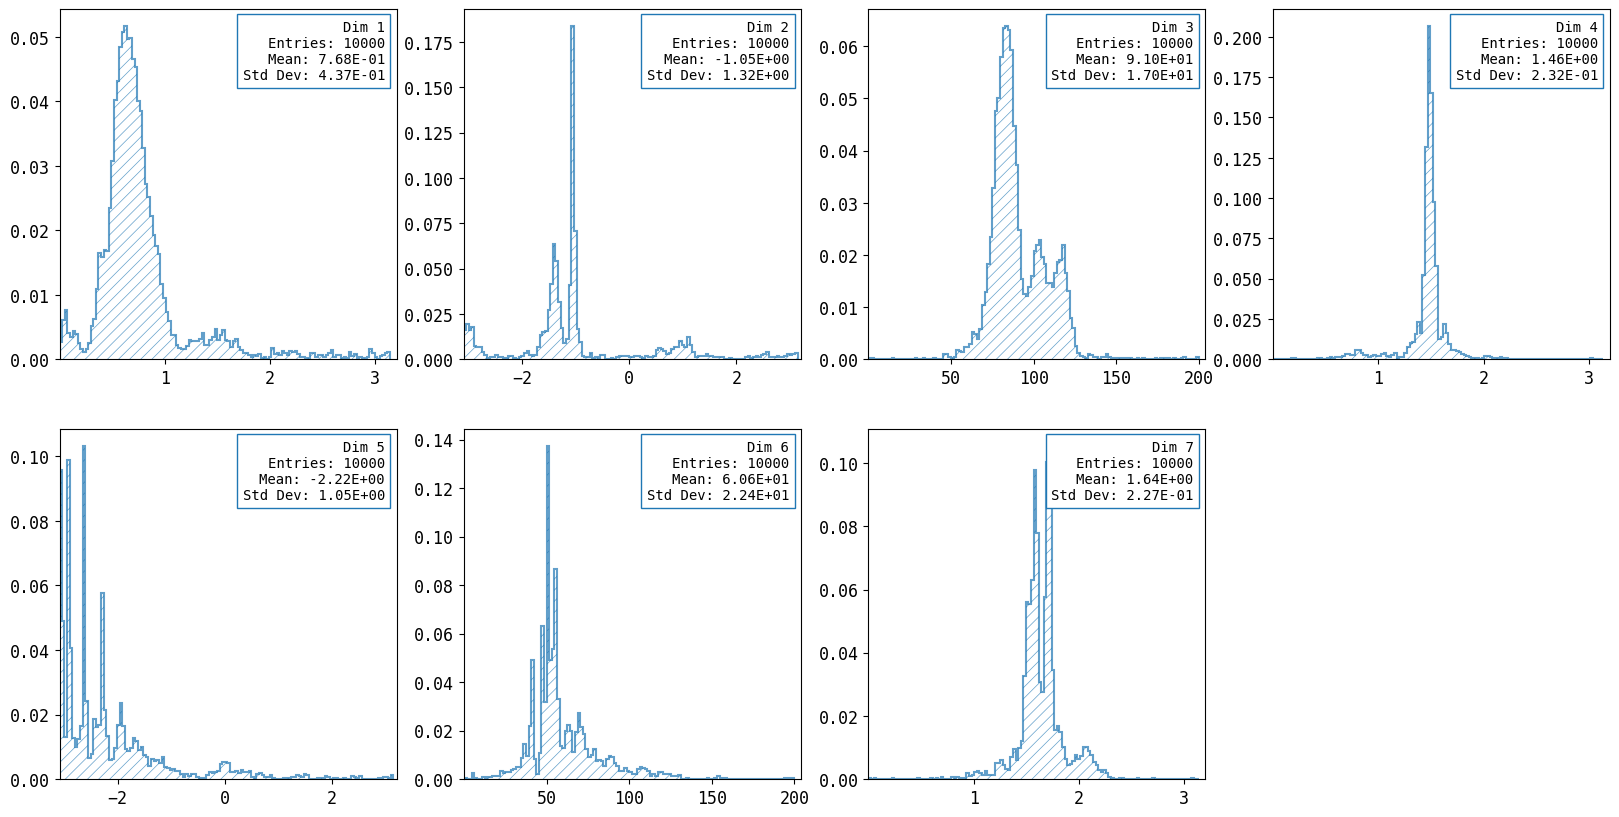

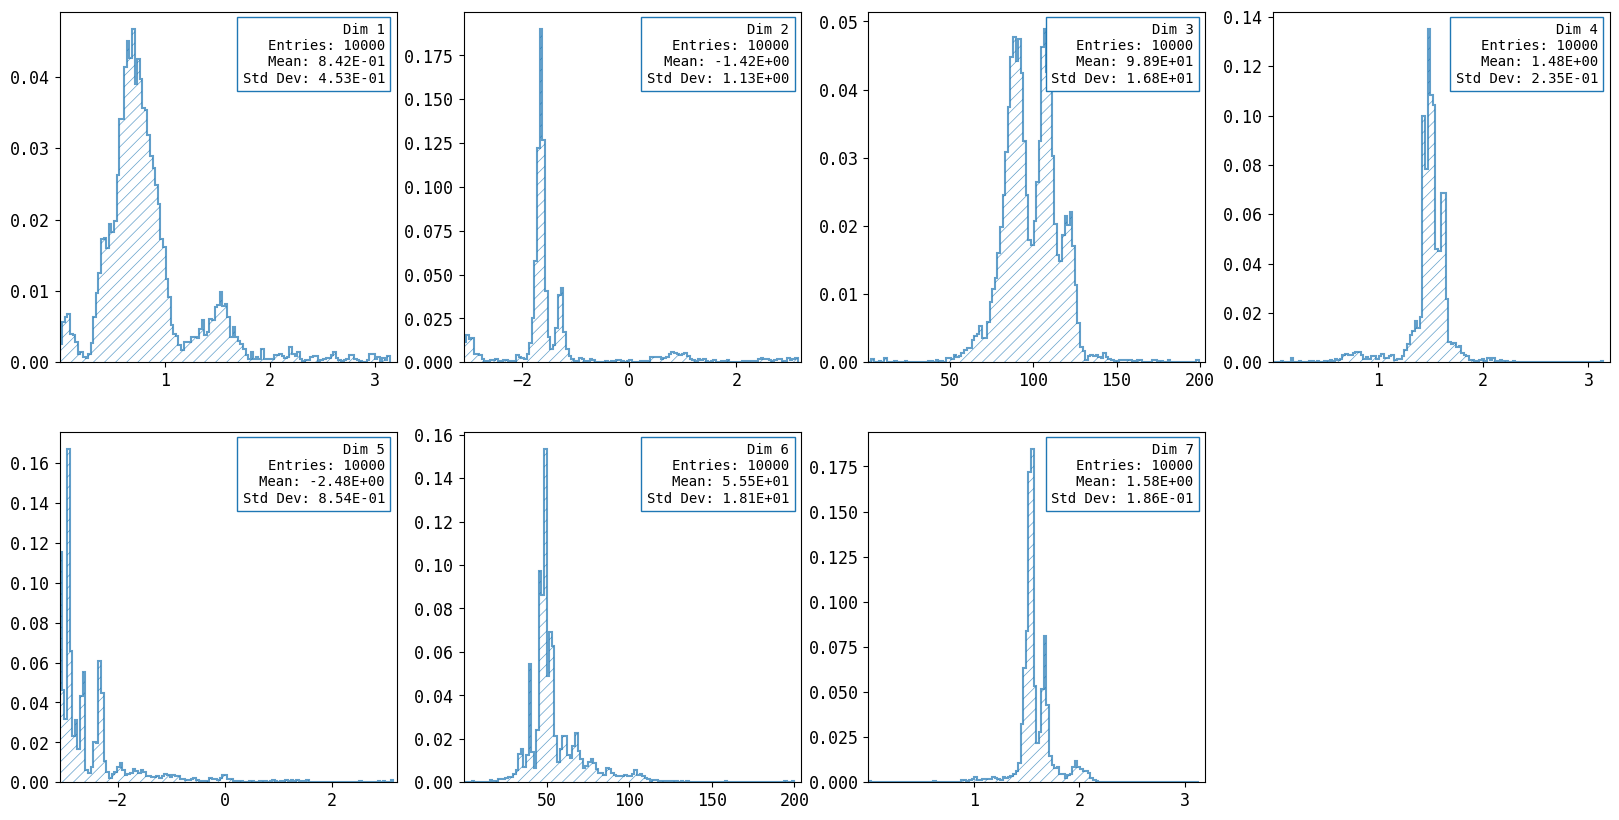

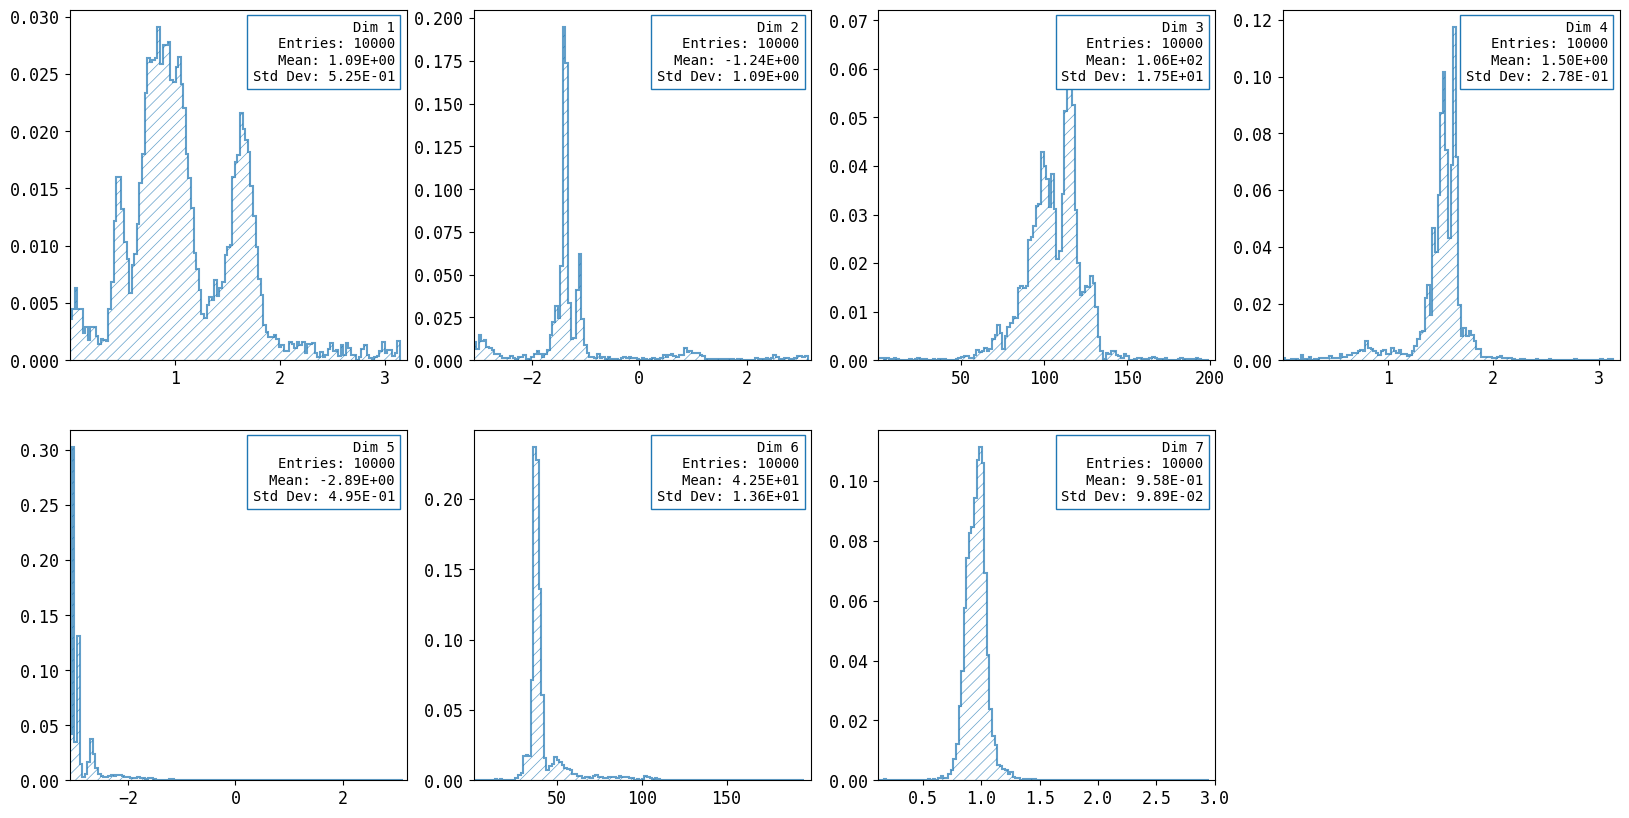

In [20]:
#@tf.function(input_signature=[tf.TensorSpec(None, tf.double)])
#def integrand(vals):
#    tf.numpy_function(test, [vals], tf.double, name='integrand')

integrate = build_integrator(dist, integrand, lr=3e-4)
means, stddevs, losses = train_iflow(integrate, 1024, 500, plot_marginals, test_callback_freq=50)

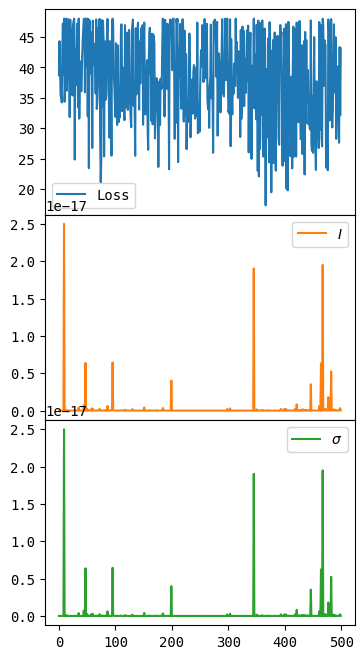

In [14]:
from analysis.plot_matplotlib import get_colorpalette

palette = get_colorpalette()
fig, ax = plt.subplots(3, 1, figsize=(4,8), gridspec_kw={'hspace': 0, 'wspace': 0})
ax[0].plot(np.arange(len(losses)), losses, label=r'Loss', color=palette[0])
ax[0].set_xlabel(r'Epoch')

ax[1].plot(np.arange(len(means)), means, label=r'$I$', color=palette[1])
ax[2].plot(np.arange(len(stddevs)), stddevs,label=r'$\sigma$', color=palette[2])

for i in range(len(ax)):
    ax[i].legend(loc='best')
    
#print(f'Estimate: {nis.evaluate()}')